# Running PySpark #


In [2]:
# Install pyspark. https://medium.com/grabngoinfo/install-pyspark-3-on-google-colab-the-easy-way-577ec4a2bcd8
!pip install pyspark

In [3]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

# Data Preparation #

In [4]:
# read the BostonHousing.csv
df = spark.read.csv("BostonHousing.csv", header=True, inferSchema=True)

# print the schema
df.printSchema()


root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [5]:
#show number of records
df.count()


506

In [6]:
#show dimension of the data
print((df.count(), len(df.columns)))

(506, 14)


In [7]:
#check missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



In [8]:
#check duplicate records for each column
df.groupBy(df.columns)\
    .count()\
    .where(col('count') > 1)\
    .show()

+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+-----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|count|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+-----+
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+-----+



In [9]:
#show the first 5 rows
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



# Analysis #

In [10]:
#show the summary statistics
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

In [11]:
#summarzing the data
df.summary().show()


+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

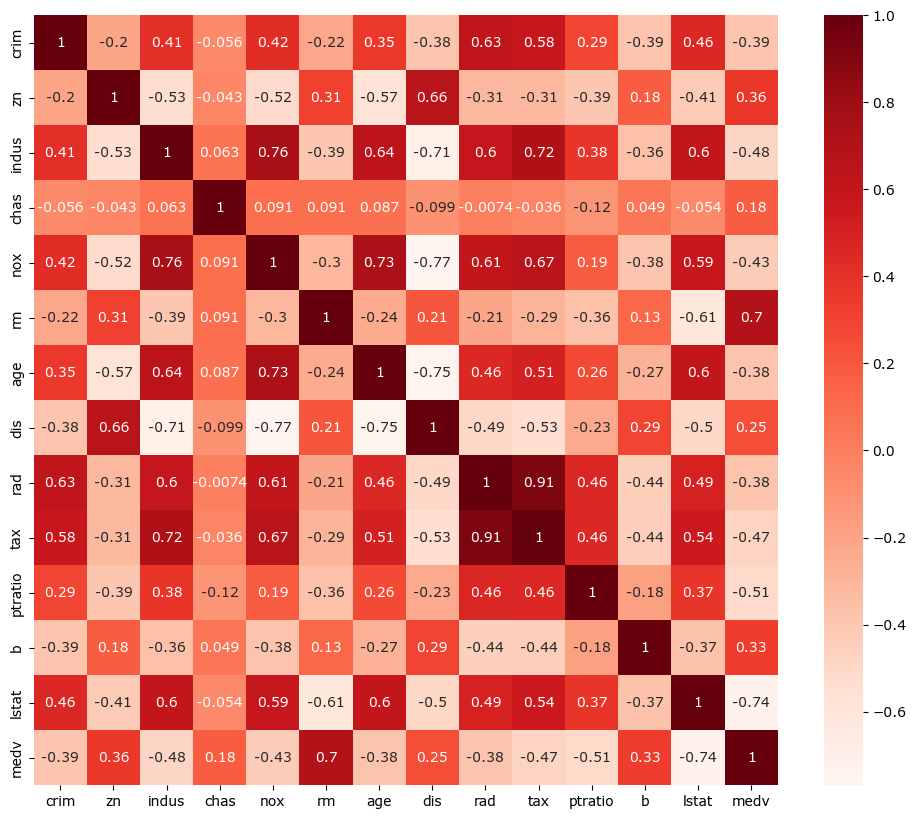

In [12]:
#plot a correlation matrix for the variables
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
cor = df.toPandas().corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

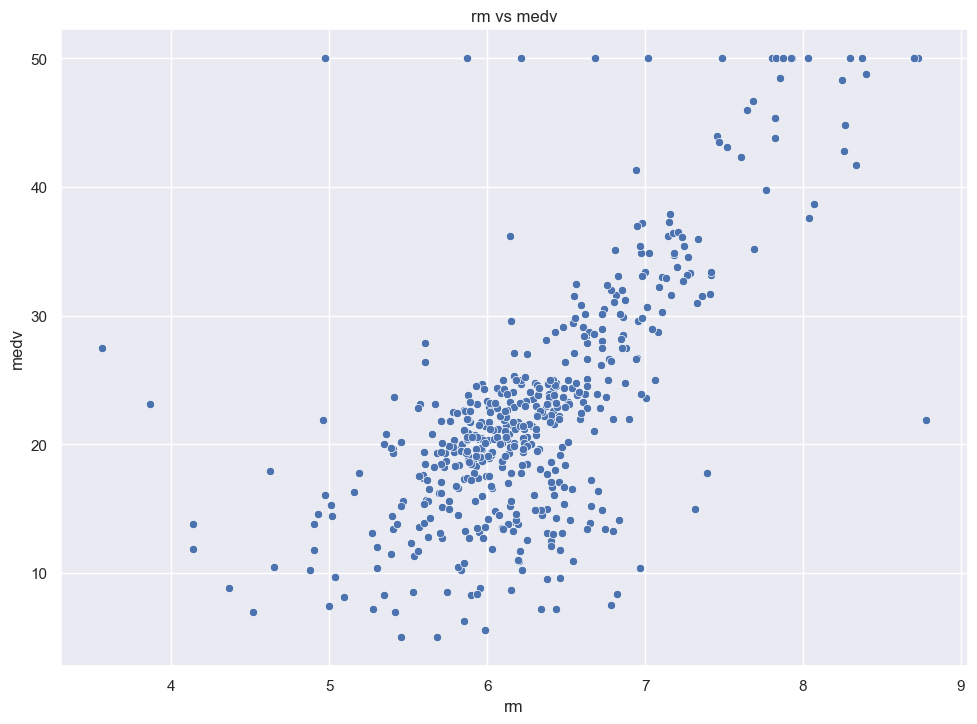

In [14]:
#create a scatter plot of rm vs medv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
df_pd = df.toPandas()
sns.scatterplot(x='rm', y='medv', data=df_pd)
plt.title("rm vs medv")
plt.show()

In [23]:
#based on the plot, count the data points for medv >45 and rm < 6
df.filter((df.medv > 45) & (df.rm < 6)).count()
 
# decide not to remove the outliers 

2

With bins

In [17]:
#create rm bins with 6 bins starting from 0 to 9
from pyspark.ml.feature import Bucketizer
splits = [0,1,2,3,4,5,6,7,8,9]                          
bucketizer = Bucketizer(splits=splits, inputCol="rm", outputCol="rm_bins")
df2 = bucketizer.setHandleInvalid("keep").transform(df)
df2.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+-------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|rm_bins|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+-------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|    6.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|    6.0|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|    7.0|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|    6.0|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|    7.0|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+-------+
only showing top 5 rows



In [18]:
# show statistics
df2.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|           rm_bins|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|             

In [19]:
#summarizing the df2 by rm_bins
df2.summary().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|           rm_bins|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|             

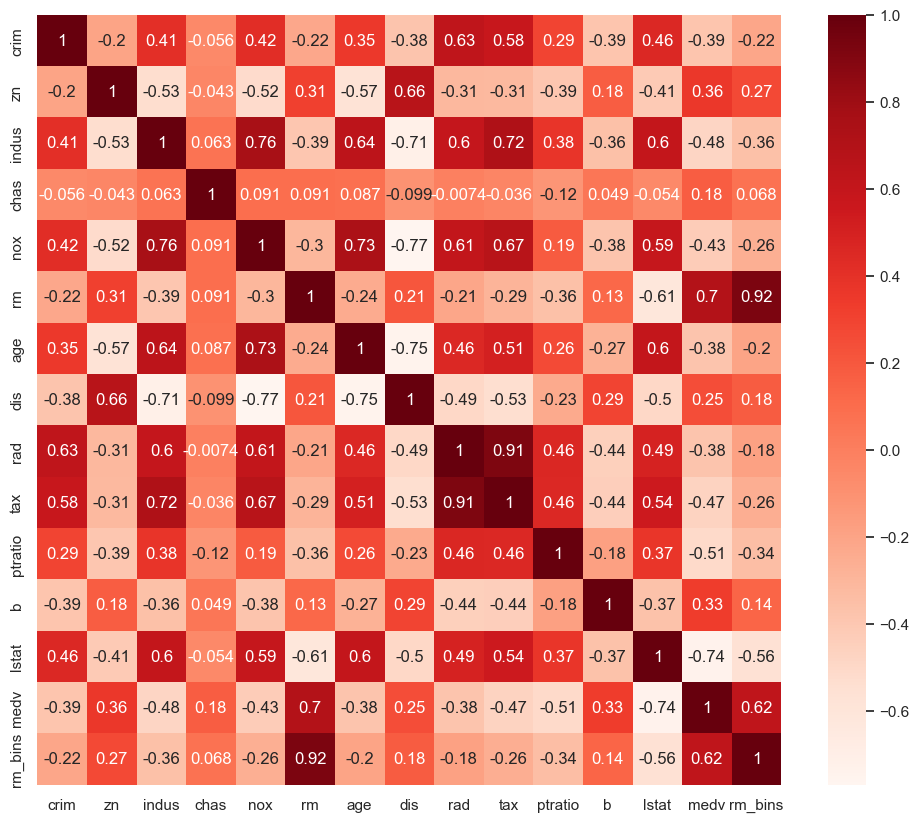

In [20]:
#plot a correlation matrix for the variables with rm_bins
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
cor = df2.toPandas().corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Statistics and Visualizations

In [21]:
from pyspark.sql.functions import min, mean, median, max, stddev, count

df2.groupBy('rm_bins').agg(
    min('medv').alias('min_medv'),
    mean('medv').alias('mean_medv'),
    median('medv').alias('median_medv'),
    max('medv').alias('max_medv'),
    stddev('medv').alias('stddev_medv'),
    count('rm_bins').alias('count_rm_bins')
).sort('rm_bins', ascending=True).show()


+-------+--------+------------------+-----------+--------+------------------+-------------+
|rm_bins|min_medv|         mean_medv|median_medv|max_medv|       stddev_medv|count_rm_bins|
+-------+--------+------------------+-----------+--------+------------------+-------------+
|    3.0|    23.1|              25.3|       25.3|    27.5|3.1112698372208083|            2|
|    4.0|     7.0|16.023076923076925|       13.8|    50.0|10.943959813991297|           13|
|    5.0|     5.0|17.487341772151893|      18.55|    50.0| 5.352667460226968|          158|
|    6.0|     7.2| 22.01598513011151|       22.2|    50.0| 6.467721594707344|          269|
|    7.0|    15.0|36.917647058823526|       35.2|    50.0| 8.316362326939656|           51|
|    8.0|    21.9|              44.2|       48.3|    50.0| 8.092383250110357|           13|
+-------+--------+------------------+-----------+--------+------------------+-------------+



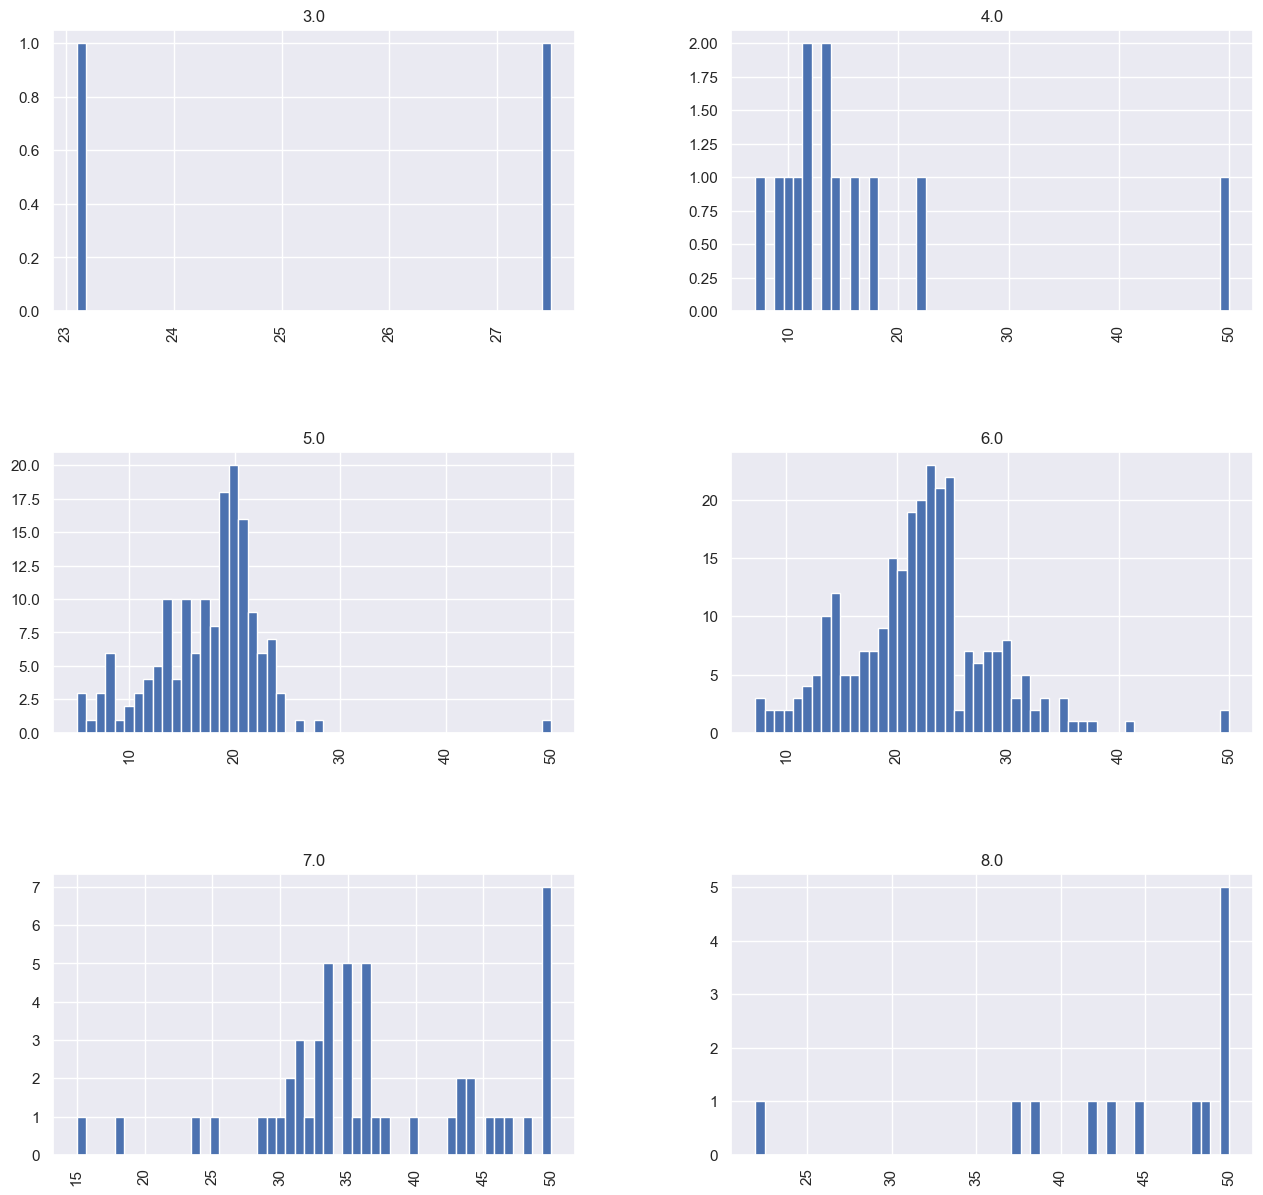

In [22]:
#create histogram for rm_bins vs medv
df2.select('rm_bins','medv').toPandas().hist(by='rm_bins',column='medv',figsize=(15,15),bins=50)
plt.show()


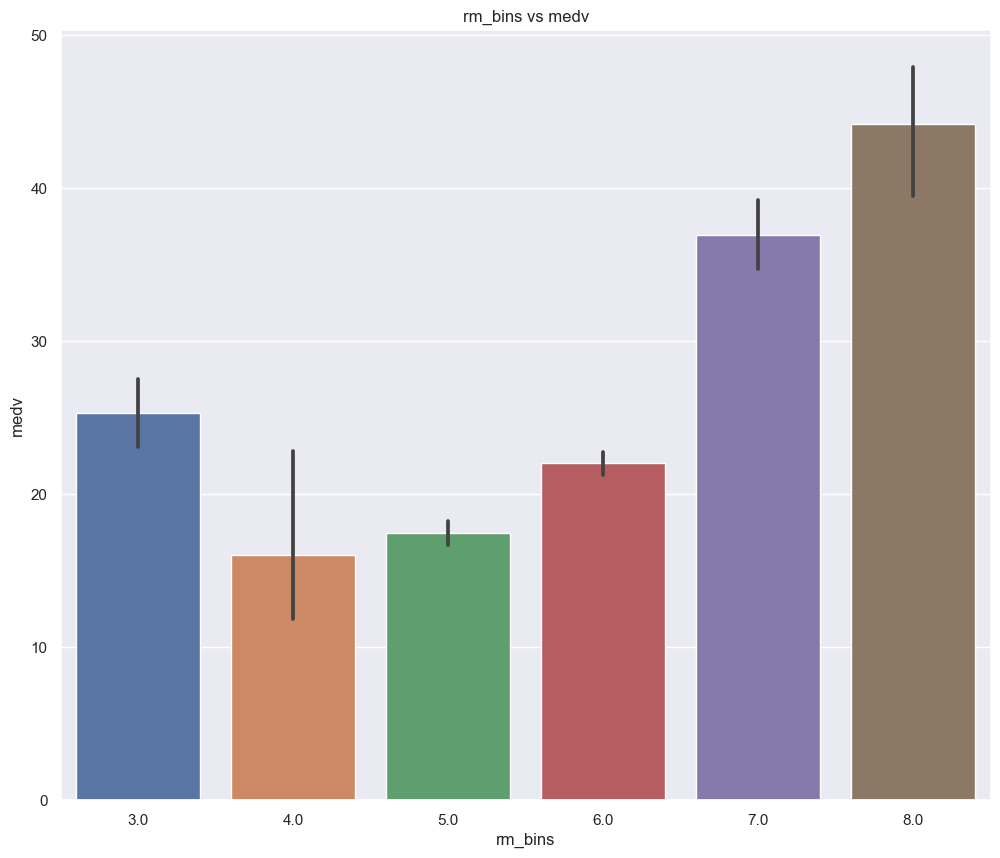

In [24]:
#create bar plot of rm_bins vs medv
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
sns.barplot(x='rm_bins', y='medv', data=df2.toPandas())
plt.title("rm_bins vs medv")
plt.show()


C:\Users\a1324\AppData\Local\Temp\ipykernel_6044\2401054709.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='rm_bins', y='medv', data=df2_pd, ci=None)


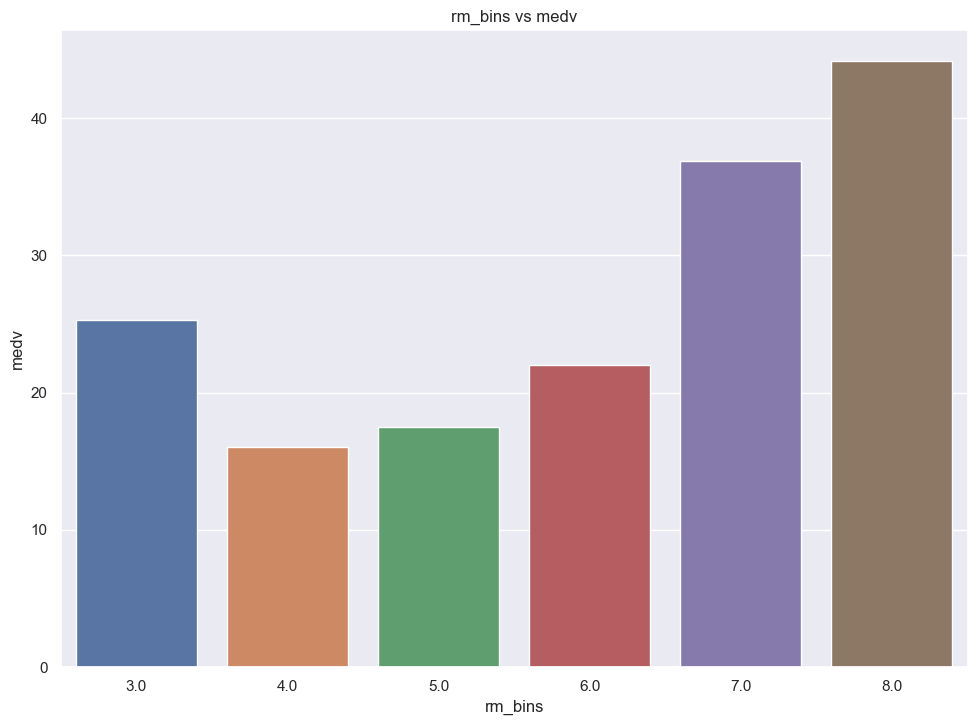

In [25]:
#create bar plot of rm_bins vs medv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
df2_pd = df2.toPandas()
sns.barplot(x='rm_bins', y='medv', data=df2_pd, ci=None)
plt.title("rm_bins vs medv")
plt.show()


In [ ]:
# spark.stop()